In [1]:
import os
import time
import sys

import numpy as np
import pylab as plt
import matplotlib as mpl
from scipy import stats

import pymc3 as pm
import theano
import theano.tensor as tt
from scipy.signal import savgol_filter

sys.path.append('/media/bigdata/firing_space_plot/ephys_data/')
import visualize as vz

## Generate synthetic data

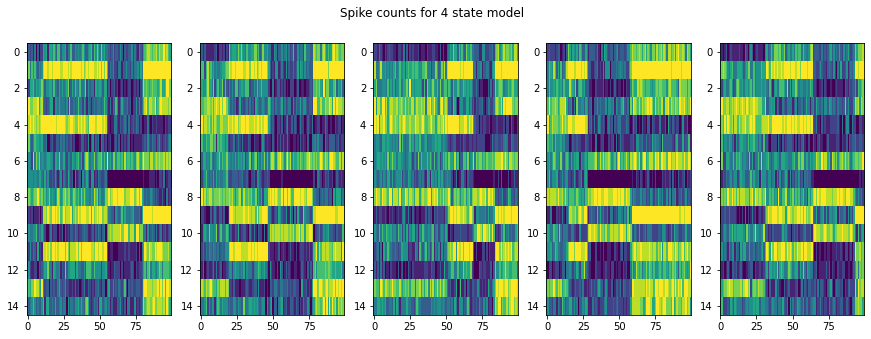

In [2]:
# Some poisson spiking
length = 1000
bin_width = 10
states = 4
nrns = 15
tastes = 4
trials = 20
idx = np.arange(length)

#true_tau = np.cumsum(np.random.random((tastes,trials,states)),axis=-1)
true_tau = np.cumsum(np.random.uniform(2,30, size = (tastes,trials,states)),axis=-1)
true_tau /= np.max(true_tau,axis=-1)[...,np.newaxis]
true_tau *= length
true_tau = np.vectorize(np.int)(true_tau)

state_inds = np.concatenate([np.zeros((tastes,trials,1)),true_tau],axis=-1)
state_inds = np.vectorize(np.int)(state_inds)

true_lambda = np.random.random((tastes,nrns,states))

true_r = np.zeros((tastes,trials, nrns, length))

for taste in range(tastes):
    for trial_num in range(trials):
        for state_num in range(states):
            true_r[taste,trial_num,:,state_inds[taste,trial_num,state_num]:state_inds[taste,trial_num,state_num+1]] = \
                            true_lambda[taste,:,state_num][:,np.newaxis]
        
data_array = np.random.random(true_r.shape) < true_r   

# Spike array : tastes x trials x neurons x timebins
spike_array = np.sum(data_array.reshape((*data_array.shape[:3],-1,bin_width)),axis=-1)
spike_array_long = np.concatenate(spike_array, axis=0) 

## Visualize some trials
taste_ind = 0
trial_count = 5

imshow_kwargs = dict(interpolation = 'nearest', aspect = 'auto')
fig,ax = plt.subplots(1,trial_count, figsize = (15,5))
for plot_dat, this_ax in zip(spike_array[taste_ind][:trial_count], ax.flatten()):
    this_ax.imshow(plot_dat, **imshow_kwargs)
plt.suptitle(f'Spike counts for {states} state model');

In [3]:
################
# Generate shuffled data
# Spike array : tastes x trials x neurons x timebins
inds = list(np.ndindex((data_array.shape[0], *data_array.shape[2:])))
shuffle_data = np.zeros(data_array.shape)

for this_ind in inds:
    shuffle_data[this_ind[0],:,this_ind[1], this_ind[2]] = np.random.permutation(data_array[this_ind[0],:,this_ind[1], this_ind[2]])
shuffle_spikes = np.sum(shuffle_data.reshape((*shuffle_data.shape[:3],-1,bin_width)),axis=-1)
shuffle_spikes = np.vectorize(np.int)(shuffle_spikes)    

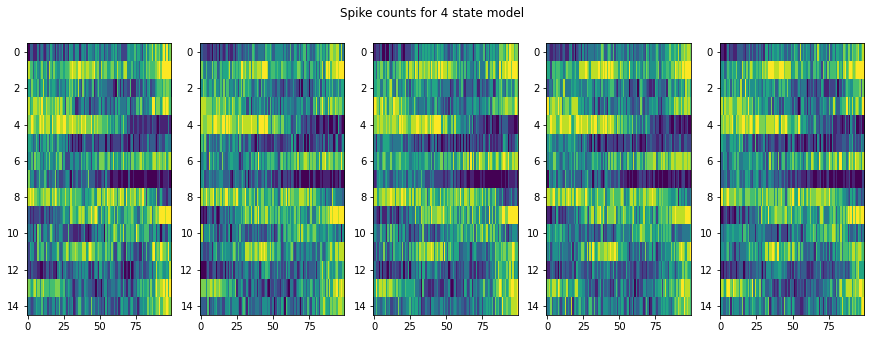

In [4]:
## Visualize some trials
taste_ind = 0
trial_count = 5

imshow_kwargs = dict(interpolation = 'nearest', aspect = 'auto')
fig,ax = plt.subplots(1,trial_count, figsize = (15,5))
for plot_dat, this_ax in zip(shuffle_spikes[taste_ind][:trial_count], ax.flatten()):
    this_ax.imshow(plot_dat, **imshow_kwargs)
plt.suptitle(f'Spike counts for {states} state model');

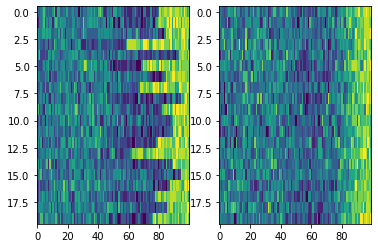

In [5]:
# Single neuron plots
fig,ax = plt.subplots(1,2)
taste_ind = 0
nrn_ind = 14
trial_ind = 10
img_kwargs = dict(aspect='auto', interpolation='nearest')
ax[0].imshow(spike_array[taste_ind,:,nrn_ind], **img_kwargs)
ax[1].imshow(shuffle_spikes[taste_ind,:,nrn_ind], **img_kwargs)

In [6]:
data_list = [spike_array[taste_ind,trial_ind,nrn_ind], shuffle_spikes[taste_ind,trial_ind,nrn_ind]]
with pm.Model() as model:
    data = pm.Data('data', data_list[0])
    step_size = pm.Exponential("step_size", 0.05)
    lambda_latent = pm.GaussianRandomWalk("volatility", sigma=step_size, shape=length//bin_width)
    lambda_ = pm.Deterministic('lambda_', np.exp(lambda_latent))
    rate = pm.Poisson("rate", lambda_, observed=data)

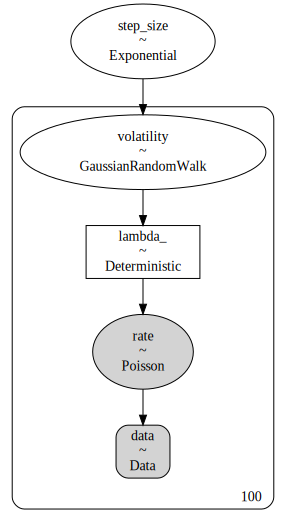

In [7]:
pm.model_to_graphviz(model)

In [128]:
trace_list = []
for this_data in data_list:
    with model:
        pm.set_data({'data': this_data})
        #trace = pm.sample()
        #trace_list.append(trace[::10])
    
        inference = pm.ADVI('full-rank')
        approx = pm.fit(n=40000, method=inference)
        trace = approx.sample(draws=2000)
        trace_list.append(trace[::10])

Finished [100%]: Average Loss = 249.36


Finished [100%]: Average Loss = 241.88


In [129]:
# thinning = 10
# trace = trace[::thinning]

In [130]:
# with model:
#     pm.traceplot(trace, var_names = ['step_size'])

In [131]:
# with model:
#     pm.autocorrplot(trace, var_names = ['step_size']);

In [132]:
ppc_list = [pm.sample_posterior_predictive(x, samples = 2000, model = model, var_names = ['lambda_']) for x in trace_list]

No handles with labels found to put in legend.


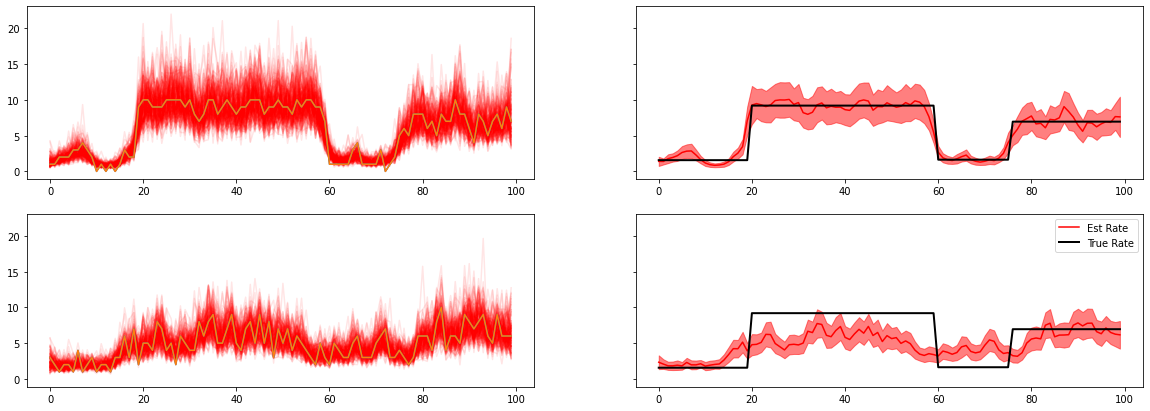

In [133]:
fig, ax = plt.subplots(2,2, figsize = (20,7), sharey = True)
#plt.ylim(0,2);
ax[0,0].plot(ppc_list[0]['lambda_'][:200].T, color = 'red', alpha = 0.1);
#ax[0].vlines(np.where(spikes)[0], ymin = 0, ymax = 1);
ax[0,0].plot(data_list[0])

ax[0,0].plot(data_list[0])
mean_firing = np.mean(ppc_list[0]['lambda_'],axis=0)
std_firing = np.std(ppc_list[0]['lambda_'],axis=0)
ax[0,1].plot(mean_firing, color = 'red', label = 'Est Rate');
ax[0,1].fill_between(np.arange(length//bin_width),
                    mean_firing - std_firing,
                      mean_firing + std_firing,
                  alpha = 0.5, color = 'red')
ax[0,1].plot(bin_width*true_r[taste_ind,trial_ind,nrn_ind,::bin_width], color = 'k', linewidth = 2, label = 'True Rate')
plt.legend()
#==========================================================
ax[1,0].plot(ppc_list[1]['lambda_'][:200].T, color = 'red', alpha = 0.1);
#ax[0].vlines(np.where(spikes)[0], ymin = 0, ymax = 1);
ax[1,0].plot(data_list[1])

ax[1,0].plot(data_list[1])
mean_firing = np.mean(ppc_list[1]['lambda_'],axis=0)
std_firing = np.std(ppc_list[1]['lambda_'],axis=0)
ax[1,1].plot(mean_firing, color = 'red', label = 'Est Rate');
ax[1,1].fill_between(np.arange(length//bin_width),
                    mean_firing - std_firing,
                      mean_firing + std_firing,
                  alpha = 0.5, color = 'red')
ax[1,1].plot(bin_width*true_r[taste_ind,trial_ind,nrn_ind,::bin_width], color = 'k', linewidth = 2, label = 'True Rate')
plt.legend()

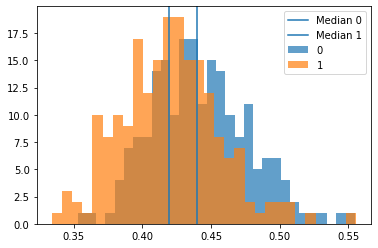

In [134]:
for num, this_trace in enumerate(trace_list):
    plt.hist(this_trace['step_size'], alpha = 0.7, label = str(num), bins = 30)
    plt.axvline(np.median(this_trace['step_size']), label = f'Median {num}')
plt.legend()

## Comparison with rolling window

Text(0.5, 1.0, 'Binned Spikes')

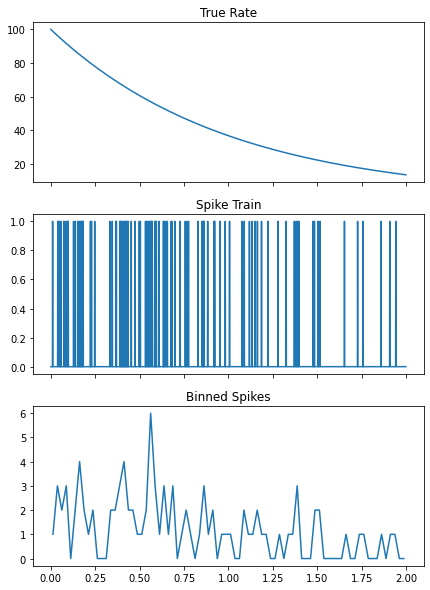

In [27]:
## Quick change at stim delivery
x = np.arange(-0.5, 2, step = 0.001)
y = np.exp(-x*1)*100
y[x<=0] = 0

y = y[x>0]
x = x[x>0]

spikes = np.random.uniform(size = len(y)) < y*0.001
bin_width = 25
binned_counts = spikes.reshape((-1, bin_width)).sum(axis=-1)
binned_x = x.reshape((-1, bin_width)).mean(axis=-1)
fig,ax = plt.subplots(3,1, figsize=(7,10), sharex=True)
ax[0].plot(x,y)
ax[0].set_title('True Rate')
ax[1].plot(x,spikes)
ax[1].set_title('Spike Train')
ax[2].plot(binned_x, binned_counts)
ax[2].set_title('Binned Spikes')

In [28]:
spike_times = x[np.where(spikes)]

In [29]:
with pm.Model() as model:
    data = pm.Data('data', binned_counts)
    step_size = pm.Exponential("step_size", 0.05)
    lambda_latent = pm.GaussianRandomWalk("volatility", sigma=step_size, shape=len(binned_counts))
    lambda_ = pm.Deterministic('lambda_', np.exp(lambda_latent))
    rate = pm.Poisson("rate", lambda_, observed=data)

In [35]:
with model:
    trace = pm.sample()
#     inference = pm.ADVI('full-rank')
#     approx = pm.fit(n=40000, method=inference)
#     trace = approx.sample(draws=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [volatility, step_size]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.48943129649852596, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


Text(0.5, 1.0, 'Lambda')

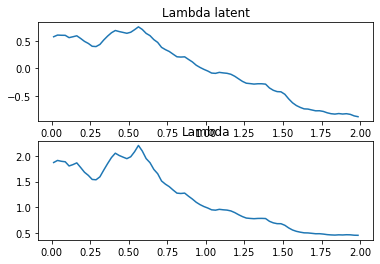

In [36]:
fig,ax = plt.subplots(2,1)
ax[0].plot(binned_x, trace['volatility'].mean(axis=0))
ax[0].set_title('Lambda latent')
ax[1].plot(binned_x, trace['lambda_'].mean(axis=0))
ax[1].set_title('Lambda')

In [37]:
def scaler(x):
    min_x,max_x = x.min(),x.max()
    return (x-min_x)/(max_x-min_x)

In [38]:
mean_rw_rate = scaler(trace['lambda_'].mean(axis=0))
std_rw_rate = scaler(trace['lambda_'].std(axis=0))

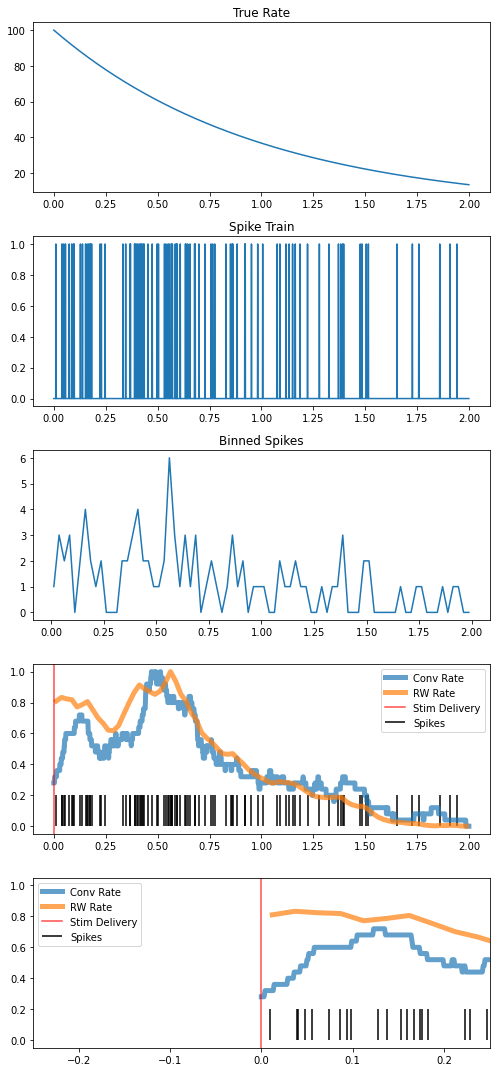

In [39]:
fig,ax = plt.subplots(5,1, figsize = (7,15))
ax[0].plot(x,y)
ax[0].set_title('True Rate')
ax[1].plot(x,spikes)
ax[1].set_title('Spike Train')
ax[2].plot(binned_x, binned_counts)
ax[2].set_title('Binned Spikes')

# Conv rate
kern_len = 250
box_kern = np.ones(kern_len)/kern_len
conv_rate = np.convolve(spikes, box_kern, mode = 'same')

ax[3].plot(x, scaler(conv_rate), label = 'Conv Rate', alpha = 0.7, linewidth = 5)
ax[3].plot(binned_x, mean_rw_rate, label = 'RW Rate', alpha = 0.7, linewidth = 5)
# ax[0].fill_between(x = binned_x,
#                   y1 = mean_rw_rate + std_rw_rate,
#                   y2 = mean_rw_rate - std_rw_rate,
#                   alpha = 0.5)
ax[3].axvline(0, color = 'red', alpha = 0.7, label='Stim Delivery')
ax[3].vlines(spike_times, ymin = 0, ymax = 0.2, color = 'k', label = 'Spikes')
ax[3].legend()


ax[4].plot(x, scaler(conv_rate), label = 'Conv Rate', alpha = 0.7, linewidth = 5)
ax[4].plot(binned_x, mean_rw_rate, label = 'RW Rate', alpha = 0.7, linewidth = 5)
# ax[1].fill_between(x = binned_x,
#                   y1 = mean_rw_rate + std_rw_rate,
#                   y2 = mean_rw_rate - std_rw_rate,
#                   alpha = 0.5)
ax[4].axvline(0, color = 'red', alpha = 0.7, label='Stim Delivery')
ax[4].vlines(spike_times, ymin = 0, ymax = 0.2, color = 'k', label = 'Spikes')
ax[4].legend()
ax[4].set_xlim([-0.25,0.25])
plt.tight_layout()